In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle
%matplotlib inline
%config InlineBackend.figure_formats=set(['svg'])

In [2]:
turbines = pd.read_csv('wind_data.csv')

power_prod=turbines.iloc[:,1:]
power_prod.drop(columns=['Theoretical_Power_Curve (KWh)'], inplace=True)
power_prod=power_prod.round(1)

def round_wind_direction(x):
    list_of_directions=[15+i*30 for i in range(11)]
    N=sum([x>i for i in list_of_directions])
    return N*30

power_prod['mean_Direction']=power_prod['Wind Direction (°)'].apply(round_wind_direction)
power_prod['Round_speed']=power_prod['Wind Speed (m/s)'].apply(lambda x: np.round(2*x)/2.0)

def energy_production(wind,direction):
    temp=power_prod[(power_prod['Round_speed']==wind) & (power_prod['mean_Direction']==direction)]['LV ActivePower (kW)']
    if temp.shape[0]==0:
        return 0
    else:
        return temp.mean()

def direction_ranking(dataset,direction):
    dir_vector=[-np.sin(direction),-np.cos(direction)]
    if direction==0:
        dataset['rank']=5-dataset['Y']
    if direction==90:
        dataset['rank']=5-dataset['X']
    if direction==180:
        dataset['rank']=dataset['X']
    if direction==270:
        dataset['rank']=dataset['Y']
    return dataset.sort_values(by='rank')   

def wake_coef(x):
    return 1-1/((1+0.08*x)**2)

def wind_coefficients(dataset, direction):
    wind_coef=np.ones(dataset.shape[0])
    if direction==0:
        for t in dataset.itertuples():
            for u in dataset.itertuples():
                if (t.X==u.X) & (t.rank<u.rank):
                    wind_coef[u.Index]*=wake_coef(abs(t.Y-u.Y))
    if direction==90:
        for t in dataset.itertuples():
            for u in dataset.itertuples():
                if (t.Y==u.Y) & (t.rank<u.rank):
                    wind_coef[u.Index]*=wake_coef(abs(t.X-u.X))
    if direction==180:
        for t in dataset.itertuples():
            for u in dataset.itertuples():
                if (t.X==u.X) & (t.rank>u.rank):
                    wind_coef[u.Index]*=wake_coef(abs(t.Y-u.Y))
    if direction==270:
        for t in dataset.itertuples():
            for u in dataset.itertuples():
                if (t.Y==u.Y) & (t.rank>u.rank):
                    wind_coef[u.Index]*=wake_coef(abs(t.X-u.X))
    return wind_coef      

def wind_grid_energy_production(dataset, wind, direction):
    total_energy=0
    direction_ranking(dataset,direction)
    wind_coef=wind_coefficients(dataset,direction)
    total_energy=sum([energy_production(i*wind,direction) for i in wind_coef])
    #dir_vector=numpy.array([cos(direction),sin(direction)])
    #for t in dataset.itertuples(index=False):
     #   for u in dataset.itertuples(index=False):
      #      if numpy.dot([u[0]-t[0],u[1]-t[1]],dir_vector)==0:
       #         print(u[0]-t[0], u[1]-t[1])
        #        wind_red=wind*0.3
         #       total_energy+=energy_production(wind_red,direction)
          #  else:
           #     total_energy+=energy_production(wind,direction)
    return total_energy

#Assigning (x, y) coordinates to grid coordinates:

# Grid coordinates:
x = ['1', '2', '3', '4']
y = ['A', 'B', 'C', 'D']

coord_grid = {}
for i in range(4): # Iterate over y coordinates
    yi = 7/8 - 0.25*i
    for j in range(4): # Iterate over x coordinates
        xi = 1/8 + 0.25*j
        coord_grid[y[i]+x[j]] = [xi, yi]

temp_dataset_max=pd.DataFrame([coord_grid['A1'], coord_grid['A2'], coord_grid['A3'], coord_grid['A4']], columns=['X','Y'])
maxwpower = wind_grid_energy_production(temp_dataset_max,5.0,0)

In [3]:
#print(coord_grid[incoord])
def gridout(incoord='B2'):
    
    temp_dataset=pd.DataFrame([coord_grid[elem.upper()] for elem in incoord.split()], columns=['X','Y'])
    perc = wind_grid_energy_production(temp_dataset,5.0,0) / maxwpower

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.25]})
    fig.subplots_adjust(wspace=0.015)


    ax1.grid(color='k', linewidth=2)
    for elem in incoord.split():
        elem = elem.upper()
        ax1.plot(coord_grid[elem][0], coord_grid[elem][1], 'kX', markersize=18)
        ax1.plot(coord_grid[elem][0]*np.ones(100), np.linspace(coord_grid[elem][1]-0.08, coord_grid[elem][1], 100), color='k', linewidth=3)

    ax1.tick_params(axis="y",direction="in")
    ax1.tick_params(axis="x",direction="in")

    ax1.yaxis.set_major_formatter(plt.NullFormatter())
    ax1.xaxis.set_major_formatter(plt.NullFormatter())

    ax1.set_xticks(np.linspace(0., 1., 5))
    ax1.set_yticks(np.linspace(0., 1., 5))

    for i in range(4):
        ax1.text(1/8 + 0.25*i, -0.05, x[i])
        ax1.text(-0.05, 7/8 - 0.25*i, y[i])

    ax1.set_facecolor('blue')
    
    ax2.grid(color='k', linewidth=2)
    ax2.tick_params(axis="y",direction="in")
    ax2.tick_params(axis="x",direction="in")
    ax2.yaxis.set_major_formatter(plt.NullFormatter())
    ax2.xaxis.set_major_formatter(plt.NullFormatter())

    ax2.set_facecolor('black')
    points = np.linspace(0., 0.8, 5)

    points_coord = []
    for i in points:
        for j in points:
            points_coord.append('%f %f' %(i, j))
        
    points_coord = np.asarray(points_coord, dtype=str)

    #perc = 0.25
    numr = int(perc*25)
    #x0, y0 = np.random.choice(points, size=(numr, 2))
    rand_points = np.random.choice(points_coord, size=numr, replace=None)
    rand_points = [np.asarray(elem.split()).astype(np.float) for elem in rand_points]

    for r in range(numr):
        rect = Rectangle(rand_points[r], 0.2, 0.2, color='y')
        ax2.add_patch(rect)

    #fig.canvas.draw_idle()
    plt.show()
    fig.clear()
    return perc

In [4]:
def callgrid():
    incoord = 'B2'
    perc = gridout(incoord)
    ii = 0
    while ii == 0:
        incoord = input('Give coordinates: ')
        if incoord != 'exit':
            clear_output()
            perc = gridout(incoord)
        else:
            ii = 1
            return perc

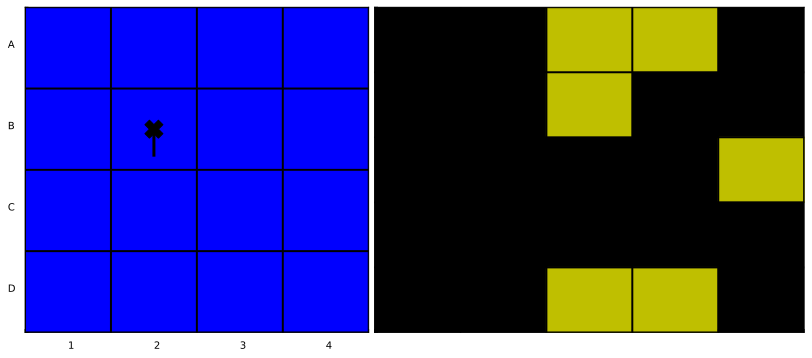

In [ ]:
perc = callgrid()